## Implementing VAE using Keras ## 
Links:

https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/

https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

from keras.datasets import mnist 
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
K.set_learning_phase(1) #set learning phase
import tensorflow as tf


m = 50
n_z = 2
n_epoch = 20


# Q(z|X) -- encoder
inputs = Input(shape=(784,))
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

Using TensorFlow backend.


In [3]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample z ~ Q(z|X)
z = Lambda(sample_z, output_shape=(n_z,))([mu, log_sigma])

In [4]:
# P(X|z) -- decoder
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)

In [5]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, mu)

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [6]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl

In [7]:
(x_trainO,y_train),(x_testO,y_test)=mnist.load_data()
#(x_train, y_train), (x_test, y_test)
x_test=x_testO.reshape(len(x_testO),np.prod(x_testO.shape[1:]))
x_train=x_trainO.reshape(len(x_trainO),np.prod(x_trainO.shape[1:]))
train_size=int(len(x_train)*0.8)
valid_size=int(len(x_train)*0.2)

## Normalizing the data between zero and 1 ## 
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
print x_test.shape
print x_train.shape

(10000, 784)
(60000, 784)


In [7]:
from keras.callbacks import ModelCheckpoint

vae.compile(optimizer='adam', loss=vae_loss)


In [8]:
Path='saved_models/Parth/weights.best.mnist.'+'vae_'+'2Layers'
print Path
checkpoint=ModelCheckpoint(filepath=Path, 
                               verbose=1, save_best_only=True)
vae.fit(x_train, x_train, validation_data=(x_test, x_test),
                shuffle=True,  callbacks=[checkpoint], verbose=1, batch_size=50, epochs=10)
'''
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=10,
        batch_size=50)
#        validation_data=(x_test, x_test))
'''

saved_models/Parth/weights.best.mnist.vae_2Layers
Epoch 1/10
60000/60000 [==============================] - 16s - loss: 181.2642    
Epoch 2/10
60000/60000 [==============================] - 17s - loss: 165.2511    
Epoch 3/10
60000/60000 [==============================] - 16s - loss: 162.3814    
Epoch 4/10
60000/60000 [==============================] - 17s - loss: 160.1234    
Epoch 5/10
60000/60000 [==============================] - 17s - loss: 158.1349    
Epoch 6/10
60000/60000 [==============================] - 17s - loss: 156.5891    
Epoch 7/10
60000/60000 [==============================] - 17s - loss: 155.4219    
Epoch 8/10
60000/60000 [==============================] - 17s - loss: 154.4714    
Epoch 9/10
60000/60000 [==============================] - 16s - loss: 153.6679    
Epoch 10/10
60000/60000 [==============================] - 16s - loss: 153.0199    


In [9]:
vae.load_weights('saved_models/Ezzat/weights.best.mnist.'+'vae_'+'2Layers')

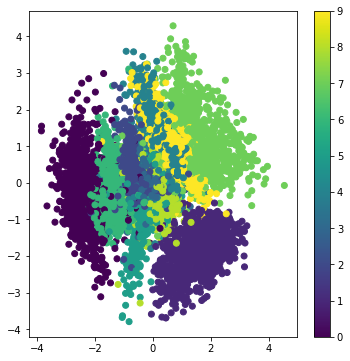

In [11]:
x_test_encoded = encoder.predict(x_test, batch_size=50)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [17]:
from sklearn.mixture import GMM 
N=10
clusterer = GMM(n_components=N, random_state=11)

clusterer.fit(x_test_encoded)

    # TODO: Predict the cluster for each data poit
preds = clusterer.predict(x_test_encoded)

    # TODO: Find the cluster centers
centers = clusterer.means_

    # TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(centers)
print sample_preds
    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
from sklearn.metrics import silhouette_score
score = silhouette_score(x_test_encoded, preds, random_state=42)
print('silhouette score for {} clusters is {}'.format(N,score))

/Users/pnsingh/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/pnsingh/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/pnsingh/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/pnsingh/anaconda/lib/python2.7/site-packages/sklearn/utils/depreca

[0 9 2 3 4 5 2 7 8 9]
silhouette score for 10 clusters is 0.334906846285
